학습에 사용된 피처
- `hour`: 예약 시간대(0~23시)
- `room_id`: 공간/룸 식별자(ID)
- `month`: 월(1~12)
- `day`: 일(1~31)
- `day_of_week`: 요일(0=월~6=일)
- `weekend_holiday_type`: 날짜 유형(0=평일, 1=토요일, 2=일요일/공휴일)
- `dow_sin`: 요일 주기성을 sin으로 인코딩
- `dow_cos`: 요일 주기성을 cos으로 인코딩
- `week_of_year`: 연중 주차(1~53)
- `is_semester`: 학기 중 여부(1=학기, 0=방학/비학기)
- `is_exam_period`: 시험 기간 여부(1=시험기간, 0=아님)
- `exam_urgency`: 시험 임박도(가까울수록 값 증가)
- `weeks_from_start`: 개강 후 경과 주차(학기 시작 기준)
- `is_festival`: 축제 기간 여부(1=축제기간, 0=아님)
- `is_holiday_next`: 다음날이 휴일/주말인지 여부
- `number_symbolism`: 7=+1, 4=-1, 그외 0
- `ui_list_order`: UI 리스트 노출 순서(작은 방 번호 상단 가정, log 변환)
- `global_reserve_rate`: 시간대별 전체 평균 예약률(훈련 데이터 기반)
- `dow_hour_avg`: 요일×시간대 평균 예약률(훈련 데이터 기반)
- `avg_lag2_month`: 2개월 전 동일 룸×시간대 월평균 예약률(훈련 데이터 기반)
- `avg_lag3_month`: 3개월 전 동일 룸×시간대 월평균 예약률(훈련 데이터 기반)
- `trend_slope_lag`: (2개월 전 - 3개월 전) 월평균 예약률 변화량(추세)

In [82]:
import pandas as pd
import numpy as np

train = pd.read_csv('/kaggle/input/smarthon2026-data/__ - train.csv')
train

,date,hour,room_id,is_open,reserved
0,2024-03-01,10,5,0,0
1,2024-03-01,11,5,0,0
2,2024-03-01,12,5,0,0
3,2024-03-01,13,5,0,0
4,2024-03-01,14,5,0,0
...,...,...,...,...,...
33223,2025-04-30,11,13,1,0
33224,2025-04-30,12,13,1,0
33225,2025-04-30,13,13,1,1
33226,2025-04-30,14,13,1,1


In [83]:
test = pd.read_csv('/kaggle/input/smarthon2026-data/__ - test.csv')
test

,date,hour,room_id,is_open,reserved
0,2025-05-01,10,5,0,0
1,2025-05-01,11,5,0,0
2,2025-05-01,12,5,0,0
3,2025-05-01,13,5,0,0
4,2025-05-01,14,5,0,0
...,...,...,...,...,...
4753,2025-06-30,11,4,1,0
4754,2025-06-30,12,4,1,0
4755,2025-06-30,13,4,1,0
4756,2025-06-30,14,4,1,0


In [84]:
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33228 entries, 0 to 33227
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      33228 non-null  object
 1   hour      33228 non-null  int64 
 2   room_id   33228 non-null  int64 
 3   is_open   33228 non-null  int64 
 4   reserved  33228 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 1.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4758 entries, 0 to 4757
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      4758 non-null   object
 1   hour      4758 non-null   int64 
 2   room_id   4758 non-null   int64 
 3   is_open   4758 non-null   int64 
 4   reserved  4758 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 186.0+ KB
None


In [85]:
all_df = pd.concat([train, test])
all_df

,date,hour,room_id,is_open,reserved
0,2024-03-01,10,5,0,0
1,2024-03-01,11,5,0,0
2,2024-03-01,12,5,0,0
3,2024-03-01,13,5,0,0
4,2024-03-01,14,5,0,0
...,...,...,...,...,...
4753,2025-06-30,11,4,1,0
4754,2025-06-30,12,4,1,0
4755,2025-06-30,13,4,1,0
4756,2025-06-30,14,4,1,0


In [86]:
def create_time_date_features(df):
    # 날짜 타입 정리
    if df['date'].dtype == 'object':
        df['date'] = pd.to_datetime(df['date'])

    # ---------------------------------------------------------
    # 공휴일 설정 (KR, 2024~2025)
    # ---------------------------------------------------------
    holiday_list = [
        # 2024
        '2024-01-01', '2024-02-09', '2024-02-10', '2024-02-11', '2024-02-12', 
        '2024-03-01', '2024-04-10',
        '2024-05-05', '2024-05-06', '2024-05-15', 
        '2024-06-06', '2024-08-15', 
        '2024-09-16', '2024-09-17', '2024-09-18', 
        '2024-10-01', '2024-10-03', '2024-10-09', '2024-12-25',
        
        # 2025
        '2025-01-01', '2025-01-28', '2025-01-29', '2025-01-30', 
        '2025-03-01', '2025-03-03', '2025-05-05', '2025-05-06', '2025-06-06'
    ]
    holidays_dt = pd.to_datetime(holiday_list)

    # ---------------------------------------------------------
    # 기본 날짜 정보
    # ---------------------------------------------------------
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day

    # 요일 (0=월, 6=일)
    df['day_of_week'] = df['date'].dt.dayofweek

    # ---------------------------------------------------------
    # 휴일 구분 (0=평일, 1=토요일, 2=일요일/공휴일)
    # ---------------------------------------------------------
    is_public_holiday = df['date'].isin(holidays_dt)
    is_sunday = (df['day_of_week'] == 6)
    is_saturday = (df['day_of_week'] == 5)

    conditions = [
        (is_public_holiday | is_sunday),
        is_saturday
    ]
    choices = [2, 1]
    
    df['weekend_holiday_type'] = np.select(conditions, choices, default=0)

    # ---------------------------------------------------------
    # 요일 주기성 인코딩
    # ---------------------------------------------------------
    df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

    # ---------------------------------------------------------
    # 주차 정보
    # ---------------------------------------------------------
    df['week_of_year'] = df['date'].dt.isocalendar().week.astype(int)

    return df

In [87]:
class StatsFeatureGenerator:
    def __init__(self, cutoff_date=None, fillna=False):
        self.cutoff_date = pd.to_datetime(cutoff_date) if cutoff_date else None
        self.fillna = fillna
        self.global_map_ = None
        self.dow_hour_map_ = None
        self.monthly_stats_ = None

    def fit(self, df_ref):
        ref = df_ref.copy()
        ref['date'] = pd.to_datetime(ref['date'])
        ref = ref.sort_values(['date', 'hour', 'room_id'])

        # 기준일 이전 데이터만 사용
        if self.cutoff_date is not None:
            ref = ref[ref['date'] <= self.cutoff_date].copy()

        # 1) 시간대별 평균
        self.global_map_ = ref.groupby('hour')['reserved'].mean()

        # 2) 요일 + 시간대 평균
        self.dow_hour_map_ = (
            ref.groupby(['day_of_week', 'hour'])['reserved']
               .mean()
               .rename('dow_hour_avg')
               .reset_index()
        )

        # 3) 월 / 룸 / 시간 평균 (lag 계산용)
        ref['month_period'] = ref['date'].dt.to_period('M')
        self.monthly_stats_ = (
            ref.groupby(['month_period', 'room_id', 'hour'])['reserved']
               .mean()
               .rename('reserved_mean')
               .reset_index()
               .sort_values(['room_id', 'hour', 'month_period'])
        )
        return self

    def transform(self, df):
        data = df.copy()
        data['date'] = pd.to_datetime(data['date'])
        data = data.sort_values(['date', 'hour', 'room_id']).reset_index(drop=True)
        data['month_period'] = data['date'].dt.to_period('M')

        # 시간대 평균
        data['global_reserve_rate'] = data['hour'].map(self.global_map_)

        # 요일 + 시간대 평균
        data = data.merge(self.dow_hour_map_, on=['day_of_week', 'hour'], how='left')

        # lag2 / lag3
        ms = self.monthly_stats_.copy()

        lag2 = ms[['month_period', 'room_id', 'hour', 'reserved_mean']].copy()
        lag2['target_month'] = lag2['month_period'] + 2
        lag2 = lag2.rename(columns={'reserved_mean': 'avg_lag2_month'})

        lag3 = ms[['month_period', 'room_id', 'hour', 'reserved_mean']].copy()
        lag3['target_month'] = lag3['month_period'] + 3
        lag3 = lag3.rename(columns={'reserved_mean': 'avg_lag3_month'})

        data = data.merge(
            lag2[['target_month', 'room_id', 'hour', 'avg_lag2_month']],
            left_on=['month_period', 'room_id', 'hour'],
            right_on=['target_month', 'room_id', 'hour'],
            how='left'
        ).drop(columns=['target_month'])

        data = data.merge(
            lag3[['target_month', 'room_id', 'hour', 'avg_lag3_month']],
            left_on=['month_period', 'room_id', 'hour'],
            right_on=['target_month', 'room_id', 'hour'],
            how='left'
        ).drop(columns=['target_month'])

        # 최근 2개월 변화량
        data['trend_slope_lag'] = data['avg_lag2_month'] - data['avg_lag3_month']

        # 임시 컬럼 제거
        data = data.drop(columns=['month_period'])

        # 결측 처리
        if self.fillna:
            fill_cols = [
                'avg_lag2_month',
                'avg_lag3_month',
                'trend_slope_lag',
                'global_reserve_rate',
                'dow_hour_avg'
            ]
            data[fill_cols] = data[fill_cols].fillna(data[fill_cols].mean())

        return data

    def fit_transform(self, df_ref):
        return self.fit(df_ref).transform(df_ref)


In [88]:
def create_academic_features(df):
    df = df.copy()
    
    if df['date'].dtype == 'object':
        df['date'] = pd.to_datetime(df['date'])

    # =========================================================
    # 0. 기말고사 종료일
    # =========================================================
    finals_end_dates = {
        '2024-1': pd.to_datetime('2024-06-20'),
        '2024-2': pd.to_datetime('2024-12-20'),
        '2025-1': pd.to_datetime('2025-06-20')
    }

    # =========================================================
    # 1. 학기 여부
    # =========================================================
    df['is_semester'] = df['date'].dt.month.isin([3, 4, 5, 6, 9, 10, 11, 12]).astype(int)
    
    # 기말 이후 기간은 방학 처리
    mask_vac_24_1 = (df['date'] > finals_end_dates['2024-1']) & (df['date'] <= '2024-06-30')
    df.loc[mask_vac_24_1, 'is_semester'] = 0
    
    mask_vac_24_2 = (df['date'] > finals_end_dates['2024-2']) & (df['date'] <= '2024-12-31')
    df.loc[mask_vac_24_2, 'is_semester'] = 0
    
    mask_vac_25_1 = (df['date'] > finals_end_dates['2025-1']) & (df['date'] <= '2025-06-30')
    df.loc[mask_vac_25_1, 'is_semester'] = 0


    # =========================================================
    # 2. 시험 기간
    # =========================================================
    exam_ranges = [
        ('2024-04-19', '2024-04-25'), ('2024-06-14', '2024-06-20'),
        ('2024-10-19', '2024-10-25'), ('2024-12-14', '2024-12-20'),
        ('2025-04-19', '2025-04-25'), ('2025-06-14', '2025-06-20')
    ]
    
    df['is_exam_period'] = 0
    for start, end in exam_ranges:
        mask = (df['date'] >= start) & (df['date'] <= end)
        df.loc[mask, 'is_exam_period'] = 1

    # =========================================================
    # 3. 시험 임박도
    # =========================================================
    exam_starts = pd.to_datetime([x[0] for x in exam_ranges])
    exam_df = pd.DataFrame({'exam_start': exam_starts}).sort_values('exam_start')
    
    df_sorted = df.sort_values('date').copy()
    merged = pd.merge_asof(df_sorted, exam_df, left_on='date', right_on='exam_start', direction='forward')
    
    days_diff = (merged['exam_start'] - merged['date']).dt.days
    
    df_sorted['exam_urgency'] = 0.0
    valid_mask = (days_diff >= 0) & (days_diff <= 30)
    df_sorted.loc[valid_mask, 'exam_urgency'] = 1 / (days_diff[valid_mask] + 1)
    df_sorted.loc[df_sorted['is_exam_period'] == 1, 'exam_urgency'] = 1.0
    
    df['exam_urgency'] = df_sorted['exam_urgency']


    # =========================================================
    # 4. 개강 후 주차
    # =========================================================
    semester_starts = {
        '2024-1': pd.to_datetime('2024-03-04'),
        '2024-2': pd.to_datetime('2024-09-02'),
        '2025-1': pd.to_datetime('2025-03-03')
    }
    
    df['weeks_from_start'] = 0
    
    mask_24_1 = (df['date'] >= semester_starts['2024-1']) & (df['date'] <= finals_end_dates['2024-1'])
    df.loc[mask_24_1, 'weeks_from_start'] = ((df.loc[mask_24_1, 'date'] - semester_starts['2024-1']).dt.days // 7) + 1
    
    mask_24_2 = (df['date'] >= semester_starts['2024-2']) & (df['date'] <= finals_end_dates['2024-2'])
    df.loc[mask_24_2, 'weeks_from_start'] = ((df.loc[mask_24_2, 'date'] - semester_starts['2024-2']).dt.days // 7) + 1
    
    mask_25_1 = (df['date'] >= semester_starts['2025-1']) & (df['date'] <= finals_end_dates['2025-1'])
    df.loc[mask_25_1, 'weeks_from_start'] = ((df.loc[mask_25_1, 'date'] - semester_starts['2025-1']).dt.days // 7) + 1


    # =========================================================
    # 5. 축제 / 다음 날 휴일
    # =========================================================
    festival_ranges = [('2024-05-29', '2024-05-31'), ('2025-05-14', '2025-05-16')]
    df['is_festival'] = 0
    for start, end in festival_ranges:
        mask = (df['date'] >= start) & (df['date'] <= end)
        df.loc[mask, 'is_festival'] = 1

    if 'weekend_holiday_type' in df.columns:
        date_holidays = df[['date', 'weekend_holiday_type']].drop_duplicates().sort_values('date')
        date_holidays['is_holiday_next'] = (date_holidays['weekend_holiday_type'].shift(-1) >= 1).astype(float).fillna(0)
        df = df.merge(date_holidays[['date', 'is_holiday_next']], on='date', how='left')
    else:
        df['is_holiday_next'] = 0

    return df


In [89]:
def create_space_psychology_features(df):
    # ---------------------------------------------------------
    # 1. 숫자 편향
    # ---------------------------------------------------------
    room_str = df['room_id'].astype(str)
    
    conditions = [
        room_str.str.endswith('4'),
        room_str.str.endswith('7')
    ]
    choices = [-1, 1]
    
    df['number_symbolism'] = np.select(conditions, choices, default=0)

    # ---------------------------------------------------------
    # 2. UI 노출 순서
    # ---------------------------------------------------------
    # 방 번호가 작을수록 상단 노출된다고 가정
    min_room_id = df['room_id'].min()
    list_position = df['room_id'] - min_room_id
    
    df['ui_list_order'] = np.log1p(list_position)

    # 최소 예약 조건
    df['min_reserved'] = np.where(df['room_id'] == 1, 6, 3)

    return df


In [90]:
# 0) 전체 데이터 기준으로 안전한 피처 생성
all_df = pd.concat([train, test], ignore_index=True)
all_df = create_time_date_features(all_df)
all_df = create_academic_features(all_df)
all_df = create_space_psychology_features(all_df)

# 1) 다시 train / test 분리
train_base = all_df.iloc[:len(train)].copy()
test_base  = all_df.iloc[len(train):].copy()

# 2) 날짜 기준 Train / Val 분할
train_mask = train_base['date'] <= '2025-02-28'
val_mask   = (train_base['date'] >= '2025-03-01') & (train_base['date'] <= '2025-04-30')

train_part = train_base[train_mask].copy()
val_part   = train_base[val_mask].copy()

# 3) 통계 / lag 피처 (Train 기준 fit → Val/Test 변환)
stats_gen = StatsFeatureGenerator(cutoff_date='2025-02-28', fillna=False)
train_part = stats_gen.fit(train_part).transform(train_part)
val_part   = stats_gen.transform(val_part)
test_feat  = stats_gen.transform(test_base)

# 4) 최종 학습용: Train+Val 전체로 재fit 후 Test 변환
stats_gen_all = StatsFeatureGenerator(cutoff_date='2025-04-30', fillna=False)
train_all_feat = stats_gen_all.fit(train_base).transform(train_base)
test_feat_final = stats_gen_all.transform(test_base)


In [91]:
import lightgbm as lgb
from sklearn.metrics import log_loss, roc_auc_score
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 0. 기본 설정
# ---------------------------------------------------------
# 타겟 컬럼
target = 'reserved'

# 학습 제외 컬럼
drop_cols = ['date', 'reserved', 'is_open', 'min_reserved'] 

# 학습 / 테스트 데이터
train_final = train_all_feat
test_final  = test_feat_final

# 사용 피처
features = [c for c in train_final.columns if c not in drop_cols]

# 범주형 컬럼 지정
categorical_feats = ['room_id']
for col in categorical_feats:
    if col in train_final.columns:
        train_final[col] = train_final[col].astype('category')
        test_final[col] = test_final[col].astype('category')

print(f"사용 피처 수: {len(features)}")
print(f"피처 목록: {features}")

# ---------------------------------------------------------
# 1. 평가 함수
# ---------------------------------------------------------
def get_eval_scores(y_true, y_pred_proba, name="Data"):
    loss = log_loss(y_true, y_pred_proba)
    try:
        auc = roc_auc_score(y_true, y_pred_proba)
    except ValueError:
        auc = 0.5
    print(f"[{name:<10}] LogLoss: {loss:.5f} | AUC: {auc:.5f}")
    return loss, auc

# ---------------------------------------------------------
# 2. 데이터 분할
# ---------------------------------------------------------
# Train: ~ 2025-02-28
# Val  : 2025-03-01 ~ 2025-04-30
# All  : train_final 전체
# Test : test_final

X_tr = train_final[train_final['date'] <= '2025-02-28'][features]
y_tr = train_final[train_final['date'] <= '2025-02-28'][target]

X_val = train_final[train_final['date'] >= '2025-03-01'][features]
y_val = train_final[train_final['date'] >= '2025-03-01'][target]

# 전체 학습용
X_all = train_final[features]
y_all = train_final[target]

# 테스트용
X_test = test_final[features]
y_test = test_final[target]

print(
    f"Set Sizes -> "
    f"Train: {X_tr.shape[0]}, "
    f"Val: {X_val.shape[0]}, "
    f"All: {X_all.shape[0]}, "
    f"Test: {X_test.shape[0]}"
)


사용 피처 수: 22
피처 목록: ['hour', 'room_id', 'month', 'day', 'day_of_week', 'weekend_holiday_type', 'dow_sin', 'dow_cos', 'week_of_year', 'is_semester', 'is_exam_period', 'exam_urgency', 'weeks_from_start', 'is_festival', 'is_holiday_next', 'number_symbolism', 'ui_list_order', 'global_reserve_rate', 'dow_hour_avg', 'avg_lag2_month', 'avg_lag3_month', 'trend_slope_lag']
Set Sizes -> Train: 28470, Val: 4758, All: 33228, Test: 4758


In [92]:
# ---------------------------------------------------------
# 3. Step 1: Train / Val 학습 및 검증
# ---------------------------------------------------------
print("\n" + "="*40)
print("Step 1: Train / Val 학습")
print("="*40)

lgb_params = {
    'objective': 'binary',
    'metric': ['binary_logloss', 'auc'],
    'learning_rate': 0.03,
    'n_estimators': 1000,
    'random_state': 42,
    'n_jobs': -1,
    'verbose': -1
}

model_cv = lgb.LGBMClassifier(**lgb_params)
model_cv.fit(
    X_tr, y_tr,
    eval_set=[(X_tr, y_tr), (X_val, y_val)],
    eval_names=['Train', 'Valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(period=0)
    ]
)

best_iter = model_cv.best_iteration_
print(f"Best Iteration: {best_iter}")

# 성능 확인
pred_tr = model_cv.predict_proba(X_tr)[:, 1]
pred_val = model_cv.predict_proba(X_val)[:, 1]

get_eval_scores(y_tr, pred_tr, "Train")
get_eval_scores(y_val, pred_val, "Val")



Step 1: Train / Val 학습
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[150]	Train's binary_logloss: 0.313259	Train's auc: 0.933425	Valid's binary_logloss: 0.383863	Valid's auc: 0.90788
Best Iteration: 150
[Train     ] LogLoss: 0.31326 | AUC: 0.93343
[Val       ] LogLoss: 0.38386 | AUC: 0.90788


(0.38386293529931864, np.float64(0.9078797165633304))

In [93]:
# ---------------------------------------------------------
# 4. Step 2: 전체 데이터 재학습
# ---------------------------------------------------------
print("\n" + "="*40)
print("Step 2: Full Retrain")
print("="*40)

# 최적 반복 횟수 적용
lgb_params['n_estimators'] = best_iter

# 모델 생성
final_model = lgb.LGBMClassifier(**lgb_params)

# 전체 데이터 학습
final_model.fit(X_all, y_all)

# 학습 성능
pred_all = final_model.predict_proba(X_all)[:, 1]
get_eval_scores(y_all, pred_all, "Train+Val")



Step 2: Full Retrain
[Train+Val ] LogLoss: 0.32036 | AUC: 0.93283


(0.3203613967309993, np.float64(0.9328303748698399))

In [104]:
# ---------------------------------------------------------
# 5. Step 3: 테스트 성능 평가
# ---------------------------------------------------------
print("\n" + "="*40)
print("Step 3: Test Evaluation")
print("="*40)

# 예측
test_pred_proba = final_model.predict_proba(X_test)[:, 1]

# 성능 평가
loss_test, auc_test = get_eval_scores(y_test, test_pred_proba, "TEST")

# 예측 확률 저장
test_final['probability'] = test_pred_proba


Step 3: Test Evaluation
[TEST      ] LogLoss: 0.42424 | AUC: 0.88098


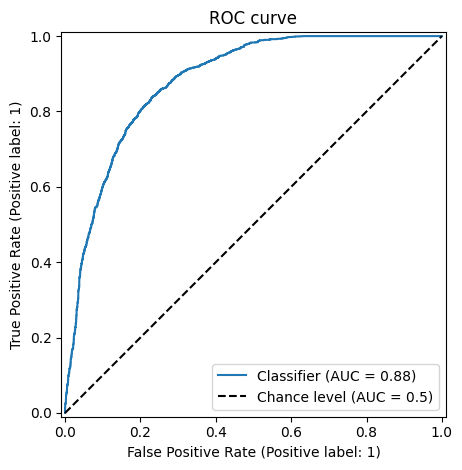

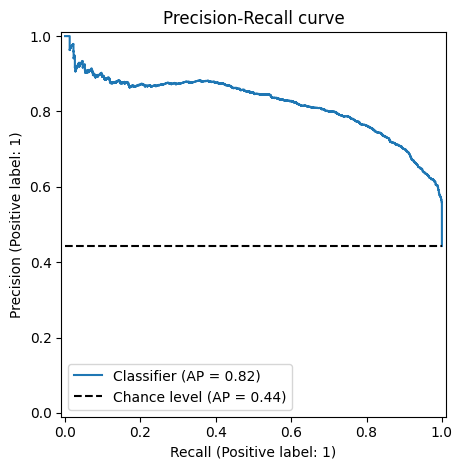

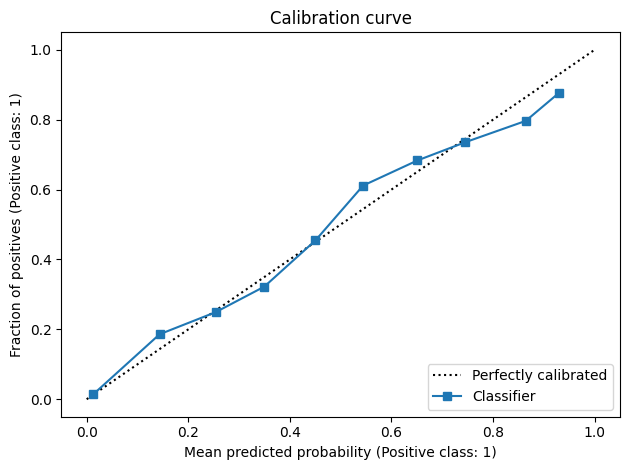

<Figure size 550x500 with 0 Axes>

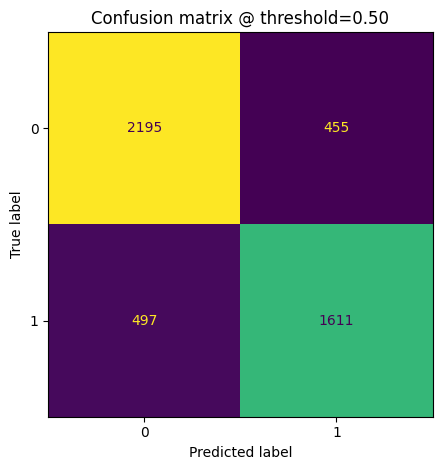

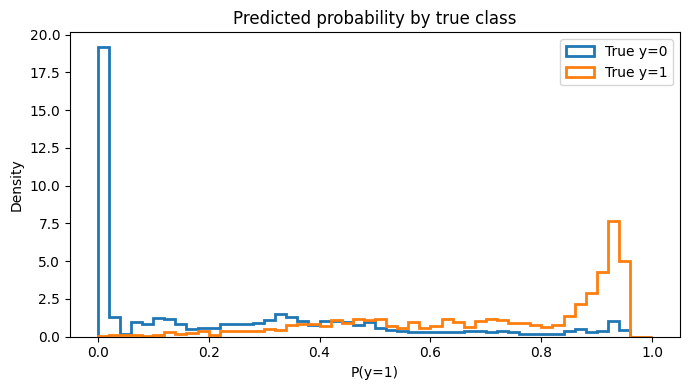

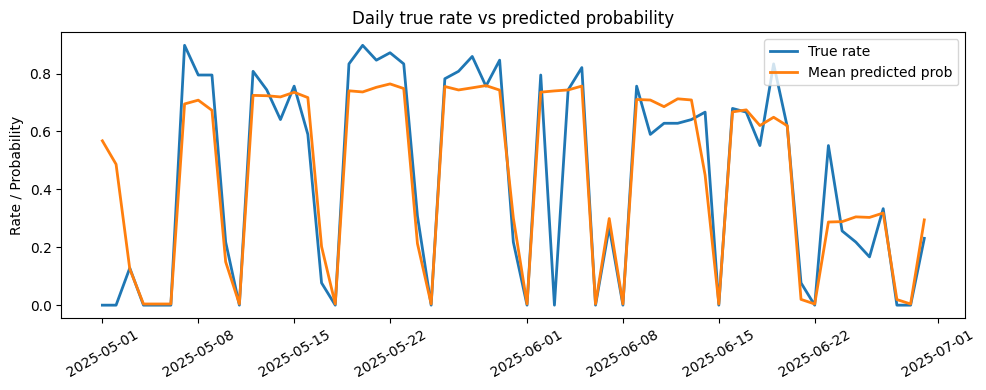

[Info] Best F1 threshold: 0.3671, F1=0.7894


In [107]:
def plot_true_pred_separate(
    y_true,
    y_pred_proba,
    df_with_date=None,
    date_col='date',
    threshold=0.5,
    bins=50
):
    y_true = np.asarray(y_true).astype(int)
    y_pred_proba = np.asarray(y_pred_proba).astype(float)

    # 1) ROC curve
    fig0 = plt.figure(figsize=(6, 5))
    RocCurveDisplay.from_predictions(y_true, y_pred_proba, plot_chance_level=True)
    if len(fig0.axes) == 0:
        plt.close(fig0)
    plt.title("ROC curve")
    plt.tight_layout()
    plt.show()

    # 2) Precision-Recall curve
    fig0 = plt.figure(figsize=(6, 5))
    PrecisionRecallDisplay.from_predictions(y_true, y_pred_proba, plot_chance_level=True)
    if len(fig0.axes) == 0:
        plt.close(fig0)
    plt.title("Precision-Recall curve")
    plt.tight_layout()
    plt.show()

    # 3) Calibration curve
    fig0 = plt.figure(figsize=(6, 5))
    CalibrationDisplay.from_predictions(y_true, y_pred_proba, n_bins=10)
    if len(fig0.axes) == 0:
        plt.close(fig0)
    plt.title("Calibration curve")
    plt.tight_layout()
    plt.show()

    # 4) Confusion matrix (threshold 기준)
    y_pred = (y_pred_proba >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

    plt.figure(figsize=(5.5, 5))
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1]).plot(colorbar=False)
    plt.title(f"Confusion matrix @ threshold={threshold:.2f}")
    plt.tight_layout()
    plt.show()

    # 5) 실제 클래스별 예측 확률 분포
    bin_edges = np.linspace(0, 1, bins + 1)

    plt.figure(figsize=(7, 4))
    plt.hist(y_pred_proba[y_true == 0], bins=bin_edges, density=True,
             histtype="step", linewidth=2, label="True y=0")
    plt.hist(y_pred_proba[y_true == 1], bins=bin_edges, density=True,
             histtype="step", linewidth=2, label="True y=1")
    plt.xlabel("P(y=1)")
    plt.ylabel("Density")
    plt.title("Predicted probability by true class")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 6) 날짜별 평균 추이
    if df_with_date is not None and date_col in df_with_date.columns:
        tmp = df_with_date.copy()
        tmp[date_col] = pd.to_datetime(tmp[date_col])
        tmp["_y_true"] = y_true
        tmp["_y_pred"] = y_pred_proba

        daily = tmp.groupby(date_col).agg(
            true_rate=("_y_true", "mean"),
            pred_mean=("_y_pred", "mean")
        )

        plt.figure(figsize=(10, 4))
        plt.plot(daily.index, daily["true_rate"], label="True rate", linewidth=2)
        plt.plot(daily.index, daily["pred_mean"], label="Mean predicted prob", linewidth=2)
        plt.title("Daily true rate vs predicted probability")
        plt.ylabel("Rate / Probability")
        plt.legend()
        plt.xticks(rotation=30)
        plt.tight_layout()
        plt.show()

    # F1 기준 최적 threshold 참고
    prec, rec, thr = precision_recall_curve(y_true, y_pred_proba)
    f1 = 2 * prec * rec / np.clip(prec + rec, 1e-12, None)
    best_idx = np.nanargmax(f1[:-1])
    print(f"[Info] Best F1 threshold: {thr[best_idx]:.4f}, F1={f1[best_idx]:.4f}")

plot_true_pred_separate(
    y_true=y_test,
    y_pred_proba=test_pred_proba,
    df_with_date=test_final,
    date_col='date',
    threshold=0.5,
    bins=50
)

In [96]:
# 필요한 컬럼만 선택
out_cols = ['date', 'hour', 'room_id', 'reserved', 'probability']
output = test_final[out_cols].copy()

# 날짜 타입 정리
output['date'] = pd.to_datetime(output['date'])

# 정렬
output = output.sort_values(['date', 'hour', 'room_id']).reset_index(drop=True)

# CSV 저장
output.to_csv('output.csv', index=False, encoding='utf-8-sig')

print(output.head())


        date  hour room_id  reserved  probability
0 2025-05-01    10       1         0     0.253358
1 2025-05-01    10       2         0     0.363104
2 2025-05-01    10       3         0     0.348377
3 2025-05-01    10       4         0     0.269222
4 2025-05-01    10       5         0     0.293040


/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


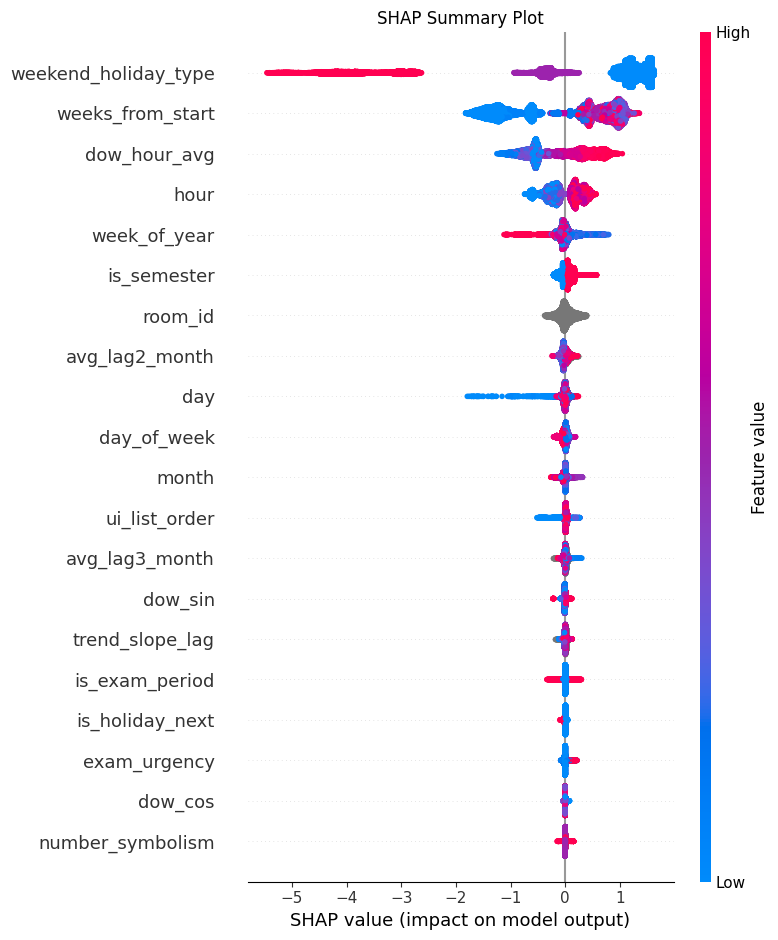

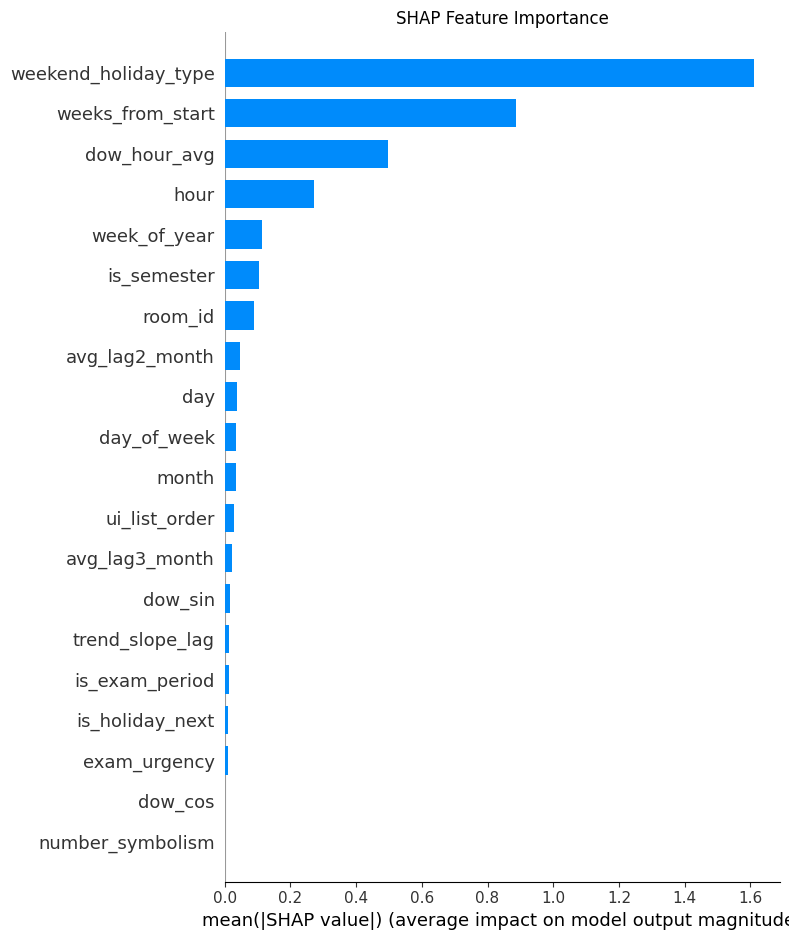

In [97]:
import shap

# ---------------------------------------------------------
# 1. SHAP explainer
# ---------------------------------------------------------
explainer = shap.TreeExplainer(final_model)

# ---------------------------------------------------------
# 2. SHAP 값 계산
# ---------------------------------------------------------
# additivity 에러 방지 옵션
shap_values = explainer.shap_values(X_all, check_additivity=False)

# Binary 분류 → class 1(예약) 기준
if isinstance(shap_values, list):
    shap_values = shap_values[1]

# ---------------------------------------------------------
# 3. Summary plot (beeswarm)
# ---------------------------------------------------------
plt.figure(figsize=(12, 14))
shap.summary_plot(shap_values, X_all, show=False)
plt.title("SHAP Summary Plot")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 4. Feature importance (bar)
# ---------------------------------------------------------
plt.figure(figsize=(10, 10))
shap.summary_plot(shap_values, X_all, plot_type="bar", show=False)
plt.title("SHAP Feature Importance")
plt.tight_layout()
plt.show()